In [1]:
# Implementation dgcnn.pytorch
# Experiment 12: Training
# 13.12.2022
# Read txt for description

In [2]:
# from main_semseg.py

from __future__ import print_function
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import numpy as np
from torch.utils.data import DataLoader
import sklearn.metrics as metrics
from tqdm import tqdm

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define util
# from util.py

import numpy as np
import torch
import torch.nn.functional as F


def cal_loss(pred, gold, smoothing=True):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.2
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        loss = -(one_hot * log_prb).sum(dim=1).mean()
    else:
        loss = F.cross_entropy(pred, gold, reduction='mean')

    return loss

In [4]:
# Define data
# from data.py

import os
import sys
import glob
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset

def load_data_semseg(partition, test_area):
    DATA_DIR = 'data'
    #prepare_test_data_semseg()
    if partition == 'train':
        data_dir = os.path.join(DATA_DIR, train_path)
    else:
        data_dir = os.path.join(DATA_DIR, test_path)
    with open(os.path.join(data_dir, "all_files.txt")) as f:
        all_files = [line.rstrip() for line in f]
    with open(os.path.join(data_dir, "room_filelist.txt")) as f:
        room_filelist = [line.rstrip() for line in f]
    data_batchlist, label_batchlist = [], []
    for f in all_files:
        file = h5py.File(os.path.join(DATA_DIR, f), 'r+')
        data = file["data"][:]
        label = file["label"][:]
        data_batchlist.append(data)
        label_batchlist.append(label)
    data_batches = np.concatenate(data_batchlist, 0)
    seg_batches = np.concatenate(label_batchlist, 0)
    test_area_name = "Area_" + test_area
    train_idxs, test_idxs = [], []
    for i, room_name in enumerate(room_filelist):
        if test_area_name in room_name:
            test_idxs.append(i)
        else:
            train_idxs.append(i)
    if partition == 'train':
        all_data = data_batches[train_idxs, ...]
        all_seg = seg_batches[train_idxs, ...]
    else:
        all_data = data_batches[test_idxs, ...]
        all_seg = seg_batches[test_idxs, ...]
    return all_data, all_seg

class S3DIS(Dataset):
    def __init__(self, num_points=4096, partition='train', test_area='1'):
        self.data, self.seg = load_data_semseg(partition, test_area)
        self.num_points = num_points
        self.partition = partition        

    def __getitem__(self, item):
        pointcloud = self.data[item][:self.num_points]
        seg = self.seg[item][:self.num_points]
        if self.partition == 'train':
            indices = list(range(pointcloud.shape[0]))
            np.random.shuffle(indices)
            pointcloud = pointcloud[indices]
            seg = seg[indices]
        seg = torch.LongTensor(seg)
        return pointcloud, seg

    def __len__(self):
        return self.data.shape[0]

In [5]:
# 3 streams then concatenate after first block
# OA = %

# Define model
# from model.py
# COPY THIS BLOCK FOR TESTING !!

import os
import sys
import copy
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F


def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx


def get_graph_feature_rgb(x, k=20, idx=None, dim9=False):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    # print('x shape', x.size())
    if idx is None:
        if dim9 == False:
            # idx = knn(x, k=k)   # (batch_size, num_points, k)
            # Use normXYZ + RGB + SWIR + geo for knn search
            idx = knn(x[:,3:], k=k)   # (batch_size, num_points, k)
        else:
            idx = knn(x[:, 6:], k=k)
    
    # only use RGB for graph feature
    x = x[:,6:9,:] # RGB
    
    device = torch.device('cuda')

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature      # (batch_size, 2*num_dims, num_points, k)

def get_graph_feature_swir(x, k=20, idx=None, dim9=False):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    # print('x shape', x.size())
    if idx is None:
        if dim9 == False:
            # idx = knn(x, k=k)   # (batch_size, num_points, k)
            # Use normXYZ + RGB + SWIR + geo for knn search
            idx = knn(x[:,3:], k=k)   # (batch_size, num_points, k)
        else:
            idx = knn(x[:, 6:], k=k)
    
    # only use SWIR for graph feature
    x = x[:,9:153,:] # SWIR
    
    device = torch.device('cuda')

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature      # (batch_size, 2*num_dims, num_points, k)

def get_graph_feature_geo(x, k=20, idx=None, dim9=False):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    # print('x shape', x.size())
    if idx is None:
        if dim9 == False:
            # idx = knn(x, k=k)   # (batch_size, num_points, k)
            # Use normXYZ + RGB + SWIR + geo for knn search
            idx = knn(x[:,3:], k=k)   # (batch_size, num_points, k)
        else:
            idx = knn(x[:, 6:], k=k)
    
    # only use geo for graph feature
    x = x[:,153:181,:] # geo
    
    device = torch.device('cuda')

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature      # (batch_size, 2*num_dims, num_points, k)

def get_graph_feature(x, k=20, idx=None, dim9=False):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        if dim9 == False:
            idx = knn(x, k=k)   # (batch_size, num_points, k)
        else:
            idx = knn(x[:, 6:], k=k)
    
    device = torch.device('cuda')

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature      # (batch_size, 2*num_dims, num_points, k)

class DGCNN_semseg(nn.Module):
    def __init__(self, args):
        super(DGCNN_semseg, self).__init__()
        self.args = args
        self.k = args_k
        
        self.bn1_rgb = nn.BatchNorm2d(64)
        self.bn2_rgb = nn.BatchNorm2d(64)

        self.bn1_swir = nn.BatchNorm3d(4)
        self.bn2_swir = nn.BatchNorm3d(4)
        self.bn3_swir = nn.BatchNorm2d(64)
        self.bn4_swir = nn.BatchNorm2d(64)
        
        self.bn1_geo = nn.BatchNorm2d(64)
        self.bn2_geo = nn.BatchNorm2d(64)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(64)        
        self.bn6 = nn.BatchNorm2d(64)


        self.bn7 = nn.BatchNorm1d(512)
        self.bn8 = nn.BatchNorm1d(256)
        
        
        # RGB
        self.conv1_rgb = nn.Sequential(nn.Conv2d(dim_rgb*2, 64, kernel_size=1, bias=False),
                                   self.bn1_rgb,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2_rgb = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn2_rgb,
                                   nn.LeakyReLU(negative_slope=0.2))

        # SWIR
        self.conv1_swir = nn.Sequential(nn.Conv3d(1, 4, kernel_size=(32,1,1), bias=False),
                                   self.bn1_swir,
                                   nn.LeakyReLU(negative_slope=0.2))      
        self.conv2_swir = nn.Sequential(nn.Conv3d(4, 4, kernel_size=(32,1,1), bias=False),
                                   self.bn2_swir,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3_swir = nn.Sequential(nn.Conv2d(dim_swir*2, 64, kernel_size=1, bias=False),
                                   self.bn3_swir,
                                   nn.LeakyReLU(negative_slope=0.2))      
        self.conv4_swir = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn4_swir,
                                   nn.LeakyReLU(negative_slope=0.2))

        
        # geo
        self.conv1_geo = nn.Sequential(nn.Conv2d(dim_geo*2, 64, kernel_size=1, bias=False),
                                   self.bn1_geo,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2_geo = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn2_geo,
                                   nn.LeakyReLU(negative_slope=0.2))
        
        # all
        self.conv1 = nn.Sequential(nn.Conv2d(196*2, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn4,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn5,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv6 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn6,
                                   nn.LeakyReLU(negative_slope=0.2))

        self.conv7 = nn.Sequential(nn.Conv1d(192, 512, kernel_size=1, bias=False),
                                   self.bn7,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv8 = nn.Sequential(nn.Conv1d(512, 256, kernel_size=1, bias=False),
                                   self.bn8,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.dp1 = nn.Dropout(p=args_dropout)
        self.conv9 = nn.Conv1d(256, args_num_class, kernel_size=1, bias=False) # CHANGE TO NUMBER OF CLASSES
        

    def forward(self, x):
        batch_size = x.size(0)
        num_points = x.size(2)
        
        # RGB
        x_rgb = get_graph_feature_rgb(x, k=self.k, dim9=False)   # (batch_size, 9, num_points) -> (batch_size, 9*2, num_points, k) 
        x_rgb = self.conv1_rgb(x_rgb)                       # (batch_size, 9*2, num_points, k) -> (batch_size, 64, num_points, k)
        x_rgb = self.conv2_rgb(x_rgb)                       # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points, k)
        x_rgb = x_rgb.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)
        
        # SWIR
        x_swir3d = get_graph_feature_swir(x, k=self.k, dim9=False)   # (batch_size, 9, num_points) -> (batch_size, 9*2, num_points, k)
        x_swir3d = x_swir3d.unsqueeze(1)
        x_swir3d = self.conv1_swir(x_swir3d)                       # (batch_size, 9*2, num_points, k) -> (batch_size, 64, num_points, k)
        x_swir3d = self.conv2_swir(x_swir3d)                       # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points, k)
        x_swir3d = x_swir3d.max(dim=2,keepdim=False)[0]
        x_swir3d = x_swir3d.max(dim=-1,keepdim=False)[0]
        
        x_swir = get_graph_feature_swir(x, k=self.k, dim9=False)   # (batch_size, 9, num_points) -> (batch_size, 9*2, num_points, k)
        x_swir = self.conv3_swir(x_swir)
        x_swir = self.conv4_swir(x_swir)
        x_swir = x_swir.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)
        
        # geo
        x_geo = get_graph_feature_geo(x, k=self.k, dim9=False)   # (batch_size, 9, num_points) -> (batch_size, 9*2, num_points, k)
        x_geo = self.conv1_geo(x_geo)                       # (batch_size, 9*2, num_points, k) -> (batch_size, 64, num_points, k)
        x_geo = self.conv2_geo(x_geo)                       # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points, k)
        x_geo = x_geo.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)
        
        x_all_cat = torch.cat((x_rgb, x_swir3d, x_swir, x_geo), dim=1) # RGB + SWIR + geo # 192 + swir3d features
        
        x_all_graph_0 = get_graph_feature(x_all_cat, k=self.k)
        x_all_1 = self.conv1(x_all_graph_0)
        x_all_2 = self.conv2(x_all_1)
        x_all_2_max = x_all_2.max(dim=-1, keepdim=False)[0]
        
        x_all_graph_1 = get_graph_feature(x_all_2_max, k=self.k)
        x_all_3 = self.conv3(x_all_graph_1)
        x_all_4 = self.conv4(x_all_3)
        x_all_4_max = x_all_4.max(dim=-1, keepdim=False)[0]
        
        x_all_graph_2 = get_graph_feature(x_all_4_max, k=self.k)
        x_all_5 = self.conv5(x_all_graph_2)
        x_all_6 = self.conv6(x_all_5)
        x_all_6_max = x_all_6.max(dim=-1, keepdim=False)[0]
        
        x_cat = torch.cat((x_all_2_max, x_all_4_max, x_all_6_max), dim=1)
        
        x_fc1 = self.conv7(x_cat)                       # (batch_size, 64*3, num_points) -> (batch_size, 512, num_points)
        x_fc2 = self.conv8(x_fc1)                       # (batch_size, 512, num_points) -> (batch_size, 256, num_points)
        x_dp = self.dp1(x_fc2)
        x_end = self.conv9(x_dp)                       # (batch_size, 256, num_points) -> (batch_size, num_class, num_points)
        
        return x_end

In [6]:
# Define Iou

def calculate_sem_IoU(pred_np, seg_np):
    I_all = np.zeros(args_num_class)
    U_all = np.zeros(args_num_class)
    for sem_idx in range(seg_np.shape[0]):
        for sem in range(args_num_class):
            I = np.sum(np.logical_and(pred_np[sem_idx] == sem, seg_np[sem_idx] == sem))
            U = np.sum(np.logical_or(pred_np[sem_idx] == sem, seg_np[sem_idx] == sem))
            I_all[sem] += I
            U_all[sem] += U
    return I_all / U_all

In [7]:
# Define Train function
# from main_semseg.py

# ----*********--*******------****-------***---*****----***
# -------***-----***--***----***-***-----***---***-***--***
# -------***-----******-----***---***----***---***--***-***
# -------***-----***--***--***-----****--***---***---******

def train():
    train_loader = DataLoader(S3DIS(partition='train', num_points=4096, test_area=args_test_area), 
                              num_workers=2, batch_size=args_batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(S3DIS(partition='test', num_points=4096, test_area=args_test_area), 
                            num_workers=2, batch_size=args_batch_size, shuffle=True, drop_last=False)

    device = torch.device("cuda" if args_cuda else "cpu")

    #Try to load models
    if args_model == 'dgcnn':
        model = DGCNN_semseg(nn.Module).to(device)
    else:
        raise Exception("Not implemented")
    print(str(model))

    model = nn.DataParallel(model)
    print("Let's use", torch.cuda.device_count(), "GPUs!")

    if args_use_sgd:
        print("Use SGD")
        opt = optim.SGD(model.parameters(), lr=args_lr*100, momentum=args_momentum, weight_decay=1e-4)
    else:
        print("Use Adam")
        opt = optim.Adam(model.parameters(), lr=args_lr, weight_decay=1e-4)

    if args_scheduler == 'cos':
        scheduler = CosineAnnealingLR(opt, args_epochs, eta_min=1e-3)
    elif args_scheduler == 'step':
        scheduler = StepLR(opt, 20, 0.5, args_epochs)

    criterion = cal_loss

    best_test_iou = 0
    best_test_acc = 0
    
    plot_train = np.zeros((args_epochs,2))
    plot_test = np.zeros((args_epochs,2))

    for epoch in range(args_epochs):
        ####################
        # Train
        ####################
        train_loss = 0.0
        count = 0.0
        model.train()
        train_true_cls = []
        train_pred_cls = []
        train_true_seg = []
        train_pred_seg = []
        train_label_seg = []
        for data, seg in train_loader:
            data, seg = data.to(device), seg.to(device)
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            opt.zero_grad()
            seg_pred = model(data)
            seg_pred = seg_pred.permute(0, 2, 1).contiguous()
            loss = criterion(seg_pred.view(-1, args_num_class), seg.view(-1,1).squeeze())
            loss.backward()
            opt.step()
            pred = seg_pred.max(dim=2)[1]               # (batch_size, num_points)
            count += batch_size
            train_loss += loss.item() * batch_size
            seg_np = seg.cpu().numpy()                  # (batch_size, num_points)
            pred_np = pred.detach().cpu().numpy()       # (batch_size, num_points)
            train_true_cls.append(seg_np.reshape(-1))       # (batch_size * num_points)
            train_pred_cls.append(pred_np.reshape(-1))      # (batch_size * num_points)
            train_true_seg.append(seg_np)
            train_pred_seg.append(pred_np)
        if args_scheduler == 'cos':
            scheduler.step()
        elif args_scheduler == 'step':
            if opt.param_groups[0]['lr'] > 1e-5:
                scheduler.step()
            if opt.param_groups[0]['lr'] < 1e-5:
                for param_group in opt.param_groups:
                    param_group['lr'] = 1e-5
        train_true_cls = np.concatenate(train_true_cls)
        train_pred_cls = np.concatenate(train_pred_cls)
        train_acc = metrics.accuracy_score(train_true_cls, train_pred_cls)
        avg_per_class_acc = metrics.balanced_accuracy_score(train_true_cls, train_pred_cls)
        train_true_seg = np.concatenate(train_true_seg, axis=0)
        train_pred_seg = np.concatenate(train_pred_seg, axis=0)
        train_ious = calculate_sem_IoU(train_pred_seg, train_true_seg)
        print('Train IoU = ', train_ious)
        print('Train mean IoU = ', np.mean(train_ious))
        print('Train loss = ', train_loss*1.0/count)
        plot_train[epoch,0] = train_loss*1.0/count
        plot_train[epoch,1] = np.mean(train_ious)
        outstr = 'Train %d, loss: %.6f, train acc: %.6f, train avg acc: %.6f, train iou: %.6f' % (epoch, 
                                                                                                  train_loss*1.0/count,
                                                                                                  train_acc,
                                                                                                  avg_per_class_acc,
                                                                                                  np.mean(train_ious))
        # io.cprint(outstr)

        ####################
        # Test
        ####################
        test_loss = 0.0
        count = 0.0
        model.eval()
        test_true_cls = []
        test_pred_cls = []
        test_true_seg = []
        test_pred_seg = []
        for data, seg in test_loader:
            data, seg = data.to(device), seg.to(device)
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            seg_pred = model(data)
            seg_pred = seg_pred.permute(0, 2, 1).contiguous()
            loss = criterion(seg_pred.view(-1, args_num_class), seg.view(-1,1).squeeze())
            pred = seg_pred.max(dim=2)[1]
            count += batch_size
            test_loss += loss.item() * batch_size
            seg_np = seg.cpu().numpy()
            pred_np = pred.detach().cpu().numpy()
            test_true_cls.append(seg_np.reshape(-1))
            test_pred_cls.append(pred_np.reshape(-1))
            test_true_seg.append(seg_np)
            test_pred_seg.append(pred_np)
        test_true_cls = np.concatenate(test_true_cls)
        test_pred_cls = np.concatenate(test_pred_cls)
        test_acc = metrics.accuracy_score(test_true_cls, test_pred_cls)
        avg_per_class_acc = metrics.balanced_accuracy_score(test_true_cls, test_pred_cls)
        test_true_seg = np.concatenate(test_true_seg, axis=0)
        test_pred_seg = np.concatenate(test_pred_seg, axis=0)
        test_ious = calculate_sem_IoU(test_pred_seg, test_true_seg)
        print('Test IoU = ', test_ious)
        print('Test mean IoU = ', np.mean(test_ious))
        print('Test loss = ', test_loss*1.0/count)
        plot_test[epoch,0] = test_loss*1.0/count
        plot_test[epoch,1] = np.mean(test_ious)
        outstr = 'Test %d, loss: %.6f, test acc: %.6f, test avg acc: %.6f, test iou: %.6f' % (epoch,
                                                                                              test_loss*1.0/count,
                                                                                              test_acc,
                                                                                              avg_per_class_acc,
                                                                                              np.mean(test_ious))
        # io.cprint(outstr)
        if np.mean(test_ious) >= best_test_iou:
            best_test_iou = np.mean(test_ious)
            torch.save(model.state_dict(), 'model_3DCNN/%s.t7' % (args_exp_name))
        if test_acc >= best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'model_3DCNN/%s_best_acc.t7' % (args_exp_name))
        
        torch.save(model.state_dict(), 'model_3DCNN/%s-%d.t7' % (args_exp_name, epoch))
        
    return plot_train, plot_test
        

In [8]:
# To train !!

# Need to change:
train_path = 'lithonet_sem_seg_hdf5_data_Experiment_12'
test_path = 'lithonet_sem_seg_hdf5_data_Experiment_12'
args_exp_name = 'Experiment_12'
args_test_area = '2'
args_epochs = 120 
args_num_class = 10
args_batch_size = 32
dim_rgb = 3
dim_swir = 144
dim_geo = 28
data_dimension = 175 # RGB, SWIR (144 features), geometric (28 features)

# Arguments no need to change (following original codes):
args_cuda = True
args_model = 'dgcnn'
args_k = 20
args_emb_dims = 1024
args_dropout = 0.5
args_use_sgd = True
args_scheduler = 'cos'
args_lr = 0.001
args_momentum = 0.9

plot_train, plot_test = train() # --> All arguments need to be resolved!!

DGCNN_semseg(
  (bn1_rgb): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_rgb): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_swir): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_swir): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3_swir): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4_swir): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_geo): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_geo): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.33134139 0.32147644 0.17026505 0.37680525 0.04396543 0.37608822
 0.3324928  0.30603598 0.024912   0.14716627]
Train mean IoU =  0.2430548835651872
Train loss =  1.808217809388512


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.49157776 0.13501438 0.10382692 0.70854552 0.08796299 0.42270597
 0.37922381 0.30735215 0.         0.35315934]
Test mean IoU =  0.29893688291783316
Test loss =  1.6025335863392427


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.58388153 0.52764572 0.30884652 0.5368767  0.22631122 0.46072584
 0.4079818  0.5653038  0.00724841 0.25387211]
Train mean IoU =  0.3878693640948875
Train loss =  1.599906264167083


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [1.31707097e-01 2.54114486e-01 1.97977361e-01 5.46292541e-01
 1.57040343e-01 1.64614595e-01 2.54129477e-01 3.37597576e-01
 2.91197111e-04 7.84398398e-02]
Test mean IoU =  0.21222045134222403
Test loss =  1.8429626415646265


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.712237   0.68760432 0.467602   0.65842558 0.38913956 0.52403569
 0.45658927 0.69922572 0.00690667 0.39055401]
Train mean IoU =  0.4992319807693832
Train loss =  1.4788318574428558


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [4.94692009e-01 1.57817834e-01 1.88177628e-01 5.14393027e-01
 1.96919008e-01 4.59672901e-01 3.74729135e-01 3.16145448e-01
 1.72922406e-04 1.17500978e-01]
Test mean IoU =  0.2820220889944455
Test loss =  1.6948095193394055


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.80081297 0.74737682 0.55258947 0.72333666 0.51919133 0.56007585
 0.4821988  0.71467702 0.0440777  0.42307902]
Train mean IoU =  0.5567415664806792
Train loss =  1.4083840313710665


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.41336518 0.24525842 0.22180342 0.52103334 0.1887659  0.3132347
 0.36361768 0.37416094 0.0193526  0.31737653]
Test mean IoU =  0.29779687152520135
Test loss =  1.6786918104180755


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.8394481  0.84465055 0.55507264 0.77159102 0.59271905 0.58376041
 0.50690529 0.78214657 0.05910663 0.50423697]
Train mean IoU =  0.6039637227108494
Train loss =  1.3618913904616707


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.63438207 0.10946293 0.20159796 0.57305227 0.14893629 0.59938622
 0.37406743 0.38253282 0.0062577  0.3277447 ]
Test mean IoU =  0.3357420388216536
Test loss =  1.5560253160493869


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.85472959 0.85585188 0.63243934 0.79051316 0.63011079 0.59894737
 0.52272491 0.78537488 0.05976198 0.50576832]
Train mean IoU =  0.623622222521095
Train loss =  1.3343683794925087


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.59646649 0.14661159 0.21924147 0.4990012  0.15703999 0.55683475
 0.46188547 0.25118892 0.04903317 0.12903003]
Test mean IoU =  0.3066333097993442
Test loss =  1.6309747446866978


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.88119636 0.89002234 0.66395693 0.83113224 0.64605954 0.6088566
 0.53463859 0.8170018  0.10081201 0.5333312 ]
Train mean IoU =  0.6507007590511391
Train loss =  1.304957760007758


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.50780287 0.22041508 0.22271193 0.52179818 0.13596829 0.52571072
 0.49453244 0.49575523 0.18027513 0.35736554]
Test mean IoU =  0.36623354248510764
Test loss =  1.58793203317265


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.89178192 0.89493943 0.67673715 0.8252553  0.6870861  0.62065189
 0.55539033 0.80721035 0.14467618 0.53370251]
Train mean IoU =  0.6637431170348783
Train loss =  1.295196333998128


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57056478 0.30679634 0.42597602 0.69457144 0.15014483 0.5518915
 0.48878513 0.42349402 0.12803451 0.37311106]
Test mean IoU =  0.41133696187698704
Test loss =  1.4542051069933883


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.883771   0.85568393 0.68245617 0.83942047 0.70839948 0.62784216
 0.56257499 0.81816153 0.15661372 0.5401224 ]
Train mean IoU =  0.6675045856058985
Train loss =  1.286488402830927


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [4.72192024e-01 3.43944006e-03 3.20768087e-01 6.70348424e-01
 1.51169611e-01 5.74059690e-01 5.03193226e-01 4.48834627e-01
 5.30835552e-04 2.75344856e-01]
Test mean IoU =  0.34198808188632834
Test loss =  1.5139991199443494


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.90640728 0.89573482 0.72778102 0.85861414 0.71467004 0.63809837
 0.57127068 0.8318909  0.21878172 0.56453962]
Train mean IoU =  0.6927788576717815
Train loss =  1.2632012822126086


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.53641991 0.24301535 0.27394345 0.55914066 0.12361202 0.5853881
 0.50317462 0.4641912  0.02593846 0.33627344]
Test mean IoU =  0.3651097206965832
Test loss =  1.565945292122627


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.91247426 0.91977221 0.73690699 0.86032142 0.72372877 0.65480741
 0.5898788  0.83914153 0.2880866  0.58778202]
Train mean IoU =  0.7112900002594332
Train loss =  1.25048649938483


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.51356502 0.26542787 0.33614115 0.67548893 0.13437489 0.43597817
 0.45863699 0.4239109  0.01955169 0.34153745]
Test mean IoU =  0.3604613066073823
Test loss =  1.5225549460684777


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.91351211 0.91073968 0.74337001 0.86423936 0.73117242 0.65898157
 0.59571535 0.8380588  0.28942238 0.58086251]
Train mean IoU =  0.7126074193222388
Train loss =  1.2455702235824184


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.5558339  0.10128772 0.29486226 0.63444341 0.14766531 0.56582187
 0.45807311 0.41695016 0.00167541 0.36461619]
Test mean IoU =  0.3541229329381193
Test loss =  1.5318532574591028


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.93225422 0.92728788 0.75724774 0.88028413 0.73904637 0.65769288
 0.59214972 0.85073777 0.32589084 0.61564763]
Train mean IoU =  0.7278239196372355
Train loss =  1.232635786658839


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.4720708  0.29821995 0.20666998 0.56022034 0.07381282 0.2916631
 0.33138278 0.42692258 0.16595766 0.18500283]
Test mean IoU =  0.30119228455198266
Test loss =  1.685835505237604


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.91495894 0.89246933 0.73380425 0.86792083 0.72605338 0.66101203
 0.59033434 0.83995204 0.33865967 0.60311225]
Train mean IoU =  0.7168277070512088
Train loss =  1.2433901397805465


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.42676176 0.04726199 0.33323584 0.65566313 0.17982574 0.54702487
 0.40689902 0.4228725  0.06609648 0.42943648]
Test mean IoU =  0.3515077810634174
Test loss =  1.5036383493424281


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.92526521 0.92015374 0.77238655 0.88031659 0.73168217 0.68302391
 0.6248833  0.85377682 0.38430186 0.61740688]
Train mean IoU =  0.7393197029875771
Train loss =  1.2165003058157469


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.63551392 0.36056258 0.35492748 0.67038927 0.21159589 0.56965892
 0.53391828 0.53371227 0.01452087 0.38245541]
Test mean IoU =  0.42672548956242873
Test loss =  1.442454430689785


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.93363097 0.91152512 0.77691949 0.89195306 0.76165553 0.68141154
 0.62022772 0.84960221 0.40967177 0.63331187]
Train mean IoU =  0.7469909273653691
Train loss =  1.2146775095086348


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.52895071 0.00829482 0.13563017 0.70734971 0.14667217 0.53455311
 0.50825256 0.28956665 0.08821237 0.44237318]
Test mean IoU =  0.33898554406469905
Test loss =  1.457731566425047


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9333091  0.93513446 0.77316709 0.8862628  0.75510772 0.68642965
 0.62795037 0.85780695 0.4277142  0.6377029 ]
Train mean IoU =  0.752058523987688
Train loss =  1.2075621909216832


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.6337249  0.13904712 0.19356273 0.47050468 0.15204548 0.56382081
 0.02895948 0.34304833 0.04861733 0.37529185]
Test mean IoU =  0.2948622711426113
Test loss =  1.7200757308049246


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.92930038 0.94153814 0.78015477 0.89373947 0.75388759 0.69006106
 0.6353795  0.86920182 0.44603665 0.65974119]
Train mean IoU =  0.7599040574585318
Train loss =  1.2019493893573159


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.39901665 0.13863176 0.37501707 0.72130684 0.16025493 0.54837379
 0.26137369 0.40783742 0.00421502 0.44393519]
Test mean IoU =  0.3459962373552673
Test loss =  1.482618562196366


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.92930795 0.930218   0.78389763 0.89676364 0.77082469 0.68346857
 0.62687416 0.86228813 0.43878174 0.65512304]
Train mean IoU =  0.7577547548332607
Train loss =  1.206553589356573


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.49772795 0.21944264 0.25374989 0.71516735 0.15527697 0.45183785
 0.4327525  0.4743654  0.08084894 0.34768393]
Test mean IoU =  0.36288534067274925
Test loss =  1.5126888942227554


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.92361001 0.929379   0.77897279 0.89307426 0.77299417 0.68864869
 0.63115057 0.86650979 0.44697327 0.665682  ]
Train mean IoU =  0.7596994538744362
Train loss =  1.2039194561933215


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [5.66853014e-01 1.51082145e-01 3.44057388e-01 4.47282412e-01
 7.35992112e-02 4.30266376e-01 4.43752693e-01 3.88878664e-01
 2.69120866e-04 4.25459643e-01]
Test mean IoU =  0.32715006659039625
Test loss =  1.673602316932891


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9221502  0.94168362 0.78444336 0.89977256 0.76191295 0.69679846
 0.64188979 0.86858649 0.46532979 0.67533655]
Train mean IoU =  0.7657903763768532
Train loss =  1.1962752295167822


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.66018792 0.31260705 0.36614961 0.68493275 0.15963411 0.66022079
 0.53186312 0.44288685 0.27103712 0.47031706]
Test mean IoU =  0.4559836392367484
Test loss =  1.3966571384108357


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.90248108 0.91465037 0.79616778 0.89432656 0.76717546 0.69471324
 0.63885881 0.85317272 0.45068394 0.64274418]
Train mean IoU =  0.7554974149194132
Train loss =  1.2044896765759117


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.5229625  0.13316283 0.30073091 0.51029721 0.27668575 0.06811807
 0.27622782 0.43940874 0.00696755 0.28320748]
Test mean IoU =  0.28177688759831576
Test loss =  1.7648461566161617


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9375263  0.94088894 0.79964474 0.90438112 0.76522377 0.70218501
 0.64566108 0.86770597 0.47775981 0.67840071]
Train mean IoU =  0.7719377451490199
Train loss =  1.1890138152398562


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.5853983  0.18612199 0.33684206 0.64243614 0.17633652 0.61441023
 0.50786994 0.45911075 0.00374473 0.38535093]
Test mean IoU =  0.3897621602181119
Test loss =  1.4703911330657986


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94256683 0.94835557 0.80346795 0.90693197 0.76978837 0.70027658
 0.64553009 0.87136011 0.51740788 0.69368109]
Train mean IoU =  0.7799366436940718
Train loss =  1.1846216713127338


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.59218648 0.31263655 0.34451229 0.64653016 0.17132348 0.55627595
 0.13950211 0.45623504 0.26818682 0.48540322]
Test mean IoU =  0.3972792093834846
Test loss =  1.4844475138192523


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94240041 0.95000765 0.8081329  0.91241997 0.77338431 0.70200898
 0.64450222 0.87658196 0.5295151  0.70568046]
Train mean IoU =  0.7844633973761204
Train loss =  1.1800392630853151


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.51734357 0.34360875 0.37129529 0.65305571 0.18621511 0.57058679
 0.44951152 0.4403245  0.18397761 0.48879894]
Test mean IoU =  0.42047177886667225
Test loss =  1.4541983806948864


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94441383 0.94500009 0.80933552 0.90967076 0.77908625 0.70811537
 0.65275554 0.87737597 0.52539117 0.69779762]
Train mean IoU =  0.7848942115508085
Train loss =  1.1783168300202018


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [4.91477093e-01 1.73645588e-01 3.67691495e-01 5.98280505e-01
 1.29288154e-01 5.36650289e-01 1.78684536e-01 4.54397914e-01
 4.67545012e-04 4.32304024e-01]
Test mean IoU =  0.33628871440226427
Test loss =  1.5410128097480993


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94319161 0.95615232 0.82099754 0.91802925 0.79887432 0.71059717
 0.65860241 0.88542587 0.5538799  0.72094104]
Train mean IoU =  0.7966691433534441
Train loss =  1.168471036772979


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.52845318 0.3518095  0.43995582 0.71587624 0.20707567 0.3946578
 0.44612836 0.53948319 0.13732301 0.45886537]
Test mean IoU =  0.42196281391158336
Test loss =  1.4730419996008757


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94454948 0.94550821 0.81827462 0.91630654 0.78658386 0.70912599
 0.65407493 0.87747474 0.53620795 0.7012773 ]
Train mean IoU =  0.7889383637995833
Train loss =  1.1745410389021824


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.48383791 0.06652751 0.38011369 0.69775325 0.15709652 0.54750271
 0.12767565 0.54656087 0.11549478 0.44391522]
Test mean IoU =  0.35664781362619524
Test loss =  1.478798873022563


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94459811 0.93932421 0.81895629 0.91477225 0.79376799 0.71582217
 0.66210598 0.88536577 0.55946474 0.72797947]
Train mean IoU =  0.7962156981053501
Train loss =  1.1689920895978023


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.54672287 0.32238058 0.36324669 0.61708993 0.13472753 0.58172696
 0.30258594 0.48483316 0.00865271 0.4015511 ]
Test mean IoU =  0.37635174719620795
Test loss =  1.5124271189588583


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94764351 0.95487733 0.81917357 0.91722935 0.7829612  0.71888944
 0.66814041 0.88024747 0.56411513 0.72623323]
Train mean IoU =  0.7979510644530837
Train loss =  1.1643260607593937


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.5601217  0.32264817 0.4159953  0.69651294 0.16220832 0.56719009
 0.57536987 0.53462309 0.27181507 0.4753798 ]
Test mean IoU =  0.4581864350429254
Test loss =  1.4153994360690156


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9520237  0.95983212 0.83439128 0.92111247 0.80009746 0.72167309
 0.66893665 0.88478122 0.57474075 0.73681175]
Train mean IoU =  0.8054400496778777
Train loss =  1.1596521844989376


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.42416933 0.36160122 0.36598142 0.69141577 0.17143814 0.50540823
 0.31971435 0.42747829 0.28719723 0.29322899]
Test mean IoU =  0.38476329495779754
Test loss =  1.5093117401048586


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94603138 0.94252114 0.82657695 0.91679602 0.7845386  0.71611681
 0.65936652 0.87875865 0.50600468 0.6896098 ]
Train mean IoU =  0.7866320545348499
Train loss =  1.1713223833786814


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.6473909  0.20257672 0.32086913 0.64307004 0.16251921 0.56810123
 0.5148535  0.4819539  0.30034488 0.17809679]
Test mean IoU =  0.4019776286573952
Test loss =  1.4874773048014662


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94499026 0.95393747 0.82298889 0.91517773 0.79170317 0.71495865
 0.66259106 0.8826269  0.53388458 0.71185616]
Train mean IoU =  0.7934714851696079
Train loss =  1.1681850380019139


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.47678047 0.26077092 0.28580738 0.56614774 0.25105505 0.52963835
 0.53988663 0.48346174 0.07090916 0.4030042 ]
Test mean IoU =  0.3867461637176911
Test loss =  1.5258649493020677


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95399235 0.96070262 0.83772969 0.92329501 0.79168874 0.72398468
 0.67115653 0.88761321 0.58343807 0.74038238]
Train mean IoU =  0.8073983285965406
Train loss =  1.1566098599057448


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.51690745 0.32522034 0.31924666 0.63185357 0.18576677 0.60192244
 0.52263791 0.41488383 0.19900498 0.4414749 ]
Test mean IoU =  0.41589188558663254
Test loss =  1.4665265101212281


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94690024 0.95500214 0.83649844 0.9225087  0.78738485 0.72635643
 0.67555869 0.88452117 0.58790045 0.74185082]
Train mean IoU =  0.8064481951273083
Train loss =  1.155878987751509


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.61524486 0.21863542 0.39071522 0.62816246 0.20374227 0.60721715
 0.56800213 0.51165221 0.34367552 0.36019822]
Test mean IoU =  0.4447245472575287
Test loss =  1.4483384025910033


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9459222  0.95595879 0.83372782 0.9210118  0.79354503 0.72744594
 0.67685844 0.88885586 0.58239639 0.73682286]
Train mean IoU =  0.8062545129557666
Train loss =  1.156082515653811


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.50232631 0.3762333  0.36218102 0.68615844 0.14816141 0.60121807
 0.49618359 0.53177829 0.12746915 0.42164048]
Test mean IoU =  0.425335006327994
Test loss =  1.4368172143979525


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95466468 0.95861667 0.83733685 0.9279605  0.80083101 0.72596643
 0.67348842 0.88620011 0.58368313 0.74231435]
Train mean IoU =  0.8091062144245823
Train loss =  1.1534708063853414


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.54780307 0.40183595 0.30848279 0.64185177 0.17091581 0.48840908
 0.49775938 0.53953249 0.20150503 0.47959641]
Test mean IoU =  0.4277691783285992
Test loss =  1.4767934077801699


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9594715  0.95725686 0.83914882 0.92079102 0.80650838 0.72973138
 0.68035832 0.89494959 0.6108375  0.75655975]
Train mean IoU =  0.8155613124994623
Train loss =  1.150147784697382


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.59586475 0.25220284 0.40743459 0.63418554 0.12075681 0.47994976
 0.49078357 0.51469259 0.00846182 0.38472027]
Test mean IoU =  0.38890525380795526
Test loss =  1.488928744180271


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94953751 0.95985726 0.83861261 0.92679502 0.80017743 0.73105778
 0.68235905 0.89530013 0.59221633 0.74696803]
Train mean IoU =  0.8122881158341292
Train loss =  1.1499072454477612


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.46869028 0.33034456 0.34271054 0.66150067 0.20303248 0.57036561
 0.60481724 0.55193533 0.25712417 0.50707949]
Test mean IoU =  0.44976003817113447
Test loss =  1.442170535428797


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9464779  0.96431955 0.84522131 0.93029987 0.80682366 0.73162395
 0.68172758 0.89293254 0.61211546 0.75286676]
Train mean IoU =  0.8164408592919579
Train loss =  1.1478058836962048


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.66172859 0.40411153 0.42906398 0.71942364 0.16495298 0.63592984
 0.56307397 0.51228533 0.31840551 0.11281774]
Test mean IoU =  0.4521793105655621
Test loss =  1.3994711619597655


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.94755059 0.96321989 0.84197797 0.92608273 0.80007955 0.72764361
 0.67675876 0.89040103 0.59961567 0.7440352 ]
Train mean IoU =  0.81173649935543
Train loss =  1.1524712161013955


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.68948132 0.30856138 0.28516142 0.62106579 0.18188191 0.39398562
 0.4449257  0.5179785  0.37496659 0.22053511]
Test mean IoU =  0.4038543341853617
Test loss =  1.519928510431464


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95539735 0.94603182 0.83370683 0.92381506 0.80945111 0.73393717
 0.68460157 0.89084241 0.55716594 0.71813012]
Train mean IoU =  0.8053079391840239
Train loss =  1.1495971146382784


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.6688256  0.28708453 0.43723214 0.68342906 0.21941092 0.61220289
 0.3451882  0.53126184 0.19977847 0.45710437]
Test mean IoU =  0.4441518030248111
Test loss =  1.413802354799121


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95168735 0.9568545  0.84398748 0.92585461 0.7956743  0.72893472
 0.67735315 0.89531566 0.59363641 0.74525214]
Train mean IoU =  0.8114550312191728
Train loss =  1.1500498244636936


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.5503255  0.32641142 0.37305214 0.68318523 0.16128016 0.61491851
 0.31311257 0.51454072 0.40377092 0.44554307]
Test mean IoU =  0.43861402404424926
Test loss =  1.4228101701810092


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95384124 0.96461062 0.84506347 0.92776843 0.79406992 0.73392822
 0.68559849 0.89740883 0.63390032 0.77449357]
Train mean IoU =  0.8210683093665215
Train loss =  1.143174514958733


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.61648781 0.40523341 0.33168413 0.65924897 0.20217385 0.59283863
 0.17424889 0.55511007 0.14774064 0.4662499 ]
Test mean IoU =  0.4151016309825727
Test loss =  1.4536692056979095


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95591529 0.96324297 0.84966538 0.93375764 0.80368716 0.73923182
 0.68932497 0.89857692 0.62374027 0.76781442]
Train mean IoU =  0.8224956830314856
Train loss =  1.1396473159915523


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.6395826  0.32635357 0.36320332 0.66408615 0.19785505 0.6625817
 0.58639487 0.49435498 0.12562364 0.46465953]
Test mean IoU =  0.45246954264078887
Test loss =  1.410369190776977


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95677482 0.95646718 0.83715735 0.92771228 0.80617504 0.73495191
 0.68436562 0.89816813 0.62716376 0.76776077]
Train mean IoU =  0.8196696860906325
Train loss =  1.1440476822225671


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.53530257 0.17548367 0.41427924 0.6834754  0.18739639 0.20168012
 0.31316905 0.46903308 0.36579432 0.33692095]
Test mean IoU =  0.3682534766976161
Test loss =  1.6132567869854915


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95529413 0.96541201 0.85237222 0.93606904 0.81330966 0.73706825
 0.68629905 0.89556255 0.62728549 0.7719607 ]
Train mean IoU =  0.8240633094009862
Train loss =  1.1402477276952643


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.50558494 0.31010421 0.30639782 0.61537504 0.18096636 0.60118752
 0.55892042 0.52428228 0.36796697 0.4961679 ]
Test mean IoU =  0.4466953451309027
Test loss =  1.4608134391838672


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96100255 0.96818141 0.85691207 0.93558677 0.80625076 0.73900589
 0.68811116 0.89928284 0.63466413 0.77936498]
Train mean IoU =  0.8268362559736622
Train loss =  1.1357578196023639


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.6126738  0.28310666 0.36227495 0.63169996 0.17364659 0.66196005
 0.56652625 0.4981839  0.10572668 0.42666519]
Test mean IoU =  0.43224640254016117
Test loss =  1.4253261206948875


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96167156 0.96761955 0.8608007  0.9384639  0.81328081 0.74254945
 0.69359429 0.9036776  0.65166071 0.78343455]
Train mean IoU =  0.8316753125397905
Train loss =  1.1305811389496452


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.62733584 0.17048268 0.351839   0.6334672  0.19101527 0.65002204
 0.54803933 0.54366762 0.11898785 0.4759318 ]
Test mean IoU =  0.43107886349998914
Test loss =  1.411437437596724


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95778449 0.97021788 0.85574278 0.93914833 0.81174651 0.74044436
 0.69051674 0.90538423 0.65032344 0.78954724]
Train mean IoU =  0.8310855998125867
Train loss =  1.1328656751858561


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.61357456 0.22905839 0.42357766 0.66277413 0.17105084 0.54921508
 0.5433902  0.52094384 0.34702935 0.43081377]
Test mean IoU =  0.4491427822876104
Test loss =  1.4307967014243193


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96130576 0.96384757 0.8593849  0.93599381 0.81507381 0.74037677
 0.69198797 0.90001238 0.63136275 0.77040832]
Train mean IoU =  0.8269754037022692
Train loss =  1.1355234651189101


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.29439419 0.02423386 0.24680939 0.49461964 0.1933345  0.530355
 0.36634877 0.28099528 0.00064807 0.20383163]
Test mean IoU =  0.2635570327304198
Test loss =  1.7462987715673262


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95060367 0.93303074 0.84808742 0.9348177  0.8218202  0.74133564
 0.69017403 0.89987057 0.60604788 0.75213025]
Train mean IoU =  0.8177918089262366
Train loss =  1.1411563158035278


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57323393 0.27299021 0.25262335 0.54391871 0.24446179 0.53988218
 0.01789292 0.29955392 0.00129707 0.29060656]
Test mean IoU =  0.30364606401479904
Test loss =  1.721608696143446


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9579434  0.9657591  0.85981383 0.937332   0.82404964 0.74154735
 0.69227702 0.90408236 0.64626201 0.78364364]
Train mean IoU =  0.8312710343942908
Train loss =  1.1333713327583514


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.49671634 0.38095956 0.40395172 0.68179122 0.20165834 0.57084468
 0.59935807 0.48339288 0.37731578 0.49519365]
Test mean IoU =  0.46911822477234894
Test loss =  1.4236419478591957


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95982516 0.97001297 0.84303957 0.93491284 0.80812378 0.74268686
 0.69367101 0.90493969 0.66174671 0.78724494]
Train mean IoU =  0.8306203525983783
Train loss =  1.1328403196836774


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.59250064 0.26049759 0.39761451 0.6466643  0.13730102 0.55566021
 0.53155386 0.47124915 0.30382771 0.44762387]
Test mean IoU =  0.43444928613067946
Test loss =  1.4475944331151536


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95837281 0.96346433 0.8682563  0.9396807  0.82137842 0.74211001
 0.69352387 0.9058582  0.65481293 0.78787473]
Train mean IoU =  0.8335332304900351
Train loss =  1.13032172385015


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.51173467 0.37754012 0.45988863 0.71132284 0.16425122 0.59508949
 0.4859875  0.49600719 0.33907679 0.51710575]
Test mean IoU =  0.4658004205916669
Test loss =  1.4028977283537516


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96058608 0.95970052 0.8628862  0.93751631 0.82178596 0.74550026
 0.69607565 0.90426243 0.64930493 0.78652256]
Train mean IoU =  0.8324140900543092
Train loss =  1.1306812449505454


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57561917 0.30307305 0.36294954 0.62895262 0.18216841 0.61663217
 0.59359969 0.52089906 0.18878442 0.41765437]
Test mean IoU =  0.4390332503165012
Test loss =  1.439147036047976


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95781205 0.96140959 0.8703199  0.94306257 0.82125256 0.74912479
 0.70179546 0.9098597  0.66323304 0.7925595 ]
Train mean IoU =  0.8370429172668281
Train loss =  1.1249342200003172


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.49510339 0.26325001 0.38817192 0.65780568 0.27322988 0.60120468
 0.54483589 0.48083936 0.16287873 0.45264761]
Test mean IoU =  0.43199671391910754
Test loss =  1.4549926881471043


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95471924 0.96487273 0.86991629 0.94190273 0.82172152 0.74862317
 0.70108473 0.91132892 0.6665735  0.79618561]
Train mean IoU =  0.8376928439193616
Train loss =  1.125756235499131


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.55328171 0.29097884 0.34237515 0.64975446 0.15819151 0.56361187
 0.09556378 0.44245491 0.33447787 0.4818078 ]
Test mean IoU =  0.39124979093894197
Test loss =  1.5027560229876276


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9634903  0.97063918 0.86274399 0.94322808 0.81878885 0.75001232
 0.7034318  0.90806863 0.66487401 0.79452152]
Train mean IoU =  0.8379798673415699
Train loss =  1.1239411438766278


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.4465032  0.36448405 0.34431616 0.64248463 0.1711159  0.56085401
 0.44363804 0.53414693 0.30024067 0.48971338]
Test mean IoU =  0.4297496961271701
Test loss =  1.464893170458623


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96497872 0.97387353 0.86889557 0.94476478 0.82713208 0.74879267
 0.70028476 0.90648965 0.67831629 0.80667478]
Train mean IoU =  0.842020282095359
Train loss =  1.1224220755853151


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.61311969 0.34877548 0.32081615 0.61488687 0.17166227 0.64546936
 0.46979798 0.5302106  0.38103252 0.50754749]
Test mean IoU =  0.46033184250165604
Test loss =  1.4283531318658005


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96258374 0.97052838 0.86410541 0.94188765 0.82819138 0.75125699
 0.70289109 0.90973748 0.66952121 0.80000236]
Train mean IoU =  0.840070568652022
Train loss =  1.12266028554816


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.42357841 0.26561897 0.32079594 0.62409243 0.25869197 0.56062755
 0.31332714 0.4286867  0.08952549 0.31840998]
Test mean IoU =  0.360335458232649
Test loss =  1.5638667533245274


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95610749 0.96468866 0.86440522 0.94175927 0.82778525 0.75004457
 0.70321498 0.9107515  0.66182835 0.79621053]
Train mean IoU =  0.8376795814254523
Train loss =  1.125870500740252


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.53472349 0.40258511 0.39656412 0.6793536  0.16992026 0.60162288
 0.44676697 0.50864977 0.41382084 0.4722165 ]
Test mean IoU =  0.46262235370764626
Test loss =  1.4112258302659142


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96533897 0.97126397 0.86850353 0.9444623  0.82948052 0.74834814
 0.70132061 0.90997087 0.67876726 0.80357651]
Train mean IoU =  0.8421032688007266
Train loss =  1.1224961437677081


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57342715 0.31340376 0.49593298 0.72254633 0.18955791 0.63134884
 0.57724542 0.51933551 0.26312339 0.49360356]
Test mean IoU =  0.47795248577981325
Test loss =  1.3796056702330306


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96501977 0.96363985 0.87088502 0.94579836 0.83144935 0.75189072
 0.70397991 0.91032155 0.66656042 0.79261544]
Train mean IoU =  0.8402160394244005
Train loss =  1.1221444481297542


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57957607 0.41955649 0.40422642 0.70248883 0.17482422 0.54002693
 0.54140587 0.52964664 0.23007037 0.46616387]
Test mean IoU =  0.45879856891894316
Test loss =  1.4168864121921887


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96564474 0.97039247 0.87303241 0.9435789  0.83339887 0.75279581
 0.70460082 0.90807399 0.66696468 0.79986792]
Train mean IoU =  0.8418350597188822
Train loss =  1.1205982126687701


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.58410775 0.34265203 0.37250518 0.67123075 0.18287038 0.64371886
 0.55883604 0.54136916 0.3521328  0.51028771]
Test mean IoU =  0.4759710660947647
Test loss =  1.3964580739838328


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96336638 0.97489493 0.87068842 0.94504788 0.83262051 0.75238708
 0.70617393 0.91428319 0.68457287 0.80914214]
Train mean IoU =  0.8453177330624617
Train loss =  1.119222586092196


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57887863 0.33068317 0.37498152 0.64349154 0.17921462 0.58522495
 0.59117558 0.52127245 0.349832   0.52706765]
Test mean IoU =  0.4681822117091145
Test loss =  1.418949187696875


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96722185 0.97476156 0.87329562 0.94524399 0.83420682 0.75184458
 0.70454378 0.91567213 0.68976183 0.81014139]
Train mean IoU =  0.8466693543189852
Train loss =  1.1182873954898433


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.61978858 0.29803624 0.38628321 0.65055743 0.16897203 0.62275296
 0.43850542 0.51042834 0.36599353 0.51944932]
Test mean IoU =  0.45807670557668984
Test loss =  1.4291442382596482


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96587234 0.97371089 0.87446074 0.94696356 0.8306344  0.75558034
 0.70777299 0.9164221  0.6813575  0.80787446]
Train mean IoU =  0.8460649322693241
Train loss =  1.1161106871931177


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.52008624 0.27706031 0.34622825 0.62803712 0.18187667 0.60204468
 0.51979471 0.53322269 0.28642524 0.46608686]
Test mean IoU =  0.43608627689296353
Test loss =  1.4557028537346846


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95288183 0.97073453 0.86676965 0.94219145 0.8279893  0.75314327
 0.70643201 0.91032808 0.67359875 0.79994733]
Train mean IoU =  0.840401619974019
Train loss =  1.1225651094787998


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57846634 0.3094075  0.43449131 0.68021778 0.17857153 0.53577625
 0.54368798 0.51604317 0.38950838 0.50594651]
Test mean IoU =  0.467211675027972
Test loss =  1.4263498229256315


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96748487 0.97452146 0.87730422 0.94736252 0.82932375 0.75560029
 0.70867802 0.91496937 0.69105222 0.81383532]
Train mean IoU =  0.8480132030474653
Train loss =  1.1155892500751896


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.48346029 0.22492619 0.31724856 0.61253324 0.17881105 0.6024856
 0.51836938 0.53920244 0.33149896 0.48026251]
Test mean IoU =  0.42887982234863997
Test loss =  1.4718109524746097


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96083832 0.97344341 0.87796162 0.94718091 0.82662096 0.75726362
 0.71021561 0.91731338 0.69904489 0.81683084]
Train mean IoU =  0.8486713560514643
Train loss =  1.1147432876260657


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57858157 0.33619544 0.42171318 0.66745069 0.18706883 0.61250107
 0.54794448 0.53480749 0.27640337 0.53478442]
Test mean IoU =  0.46974505384676435
Test loss =  1.4046952762812415


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96462289 0.97454335 0.87786072 0.9456735  0.83468344 0.75680346
 0.71109256 0.91734317 0.69328374 0.81496428]
Train mean IoU =  0.8490871108275716
Train loss =  1.1140530140776383


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.4893547  0.34143594 0.36720029 0.67023326 0.16703283 0.51595292
 0.55863075 0.4936945  0.25493059 0.45078861]
Test mean IoU =  0.4309254393227405
Test loss =  1.4609191763917555


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96802148 0.9753656  0.87866638 0.94958529 0.83917481 0.75786087
 0.71060678 0.91703654 0.70232137 0.8194905 ]
Train mean IoU =  0.8518129617118054
Train loss =  1.1129720101231022


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.58769389 0.31764289 0.40969176 0.65657649 0.17355172 0.53521232
 0.55119984 0.5413876  0.43459428 0.50371153]
Test mean IoU =  0.4711262308286048
Test loss =  1.43145432031395


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9665081  0.97563119 0.87688826 0.94703128 0.83169648 0.75556911
 0.70695658 0.91470015 0.68728705 0.81120981]
Train mean IoU =  0.8473478015240495
Train loss =  1.1163932649712813


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.5149688  0.38264363 0.40525521 0.68401113 0.18126986 0.47861152
 0.51746183 0.5500313  0.38648565 0.5375356 ]
Test mean IoU =  0.4638274534083842
Test loss =  1.4421033422510188


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96426177 0.96959114 0.87711995 0.94807506 0.83317685 0.75991123
 0.71373621 0.9178847  0.70172305 0.81473537]
Train mean IoU =  0.8500215330170313
Train loss =  1.1129634270542546


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.50551191 0.3080481  0.40640194 0.67944853 0.1856384  0.58651311
 0.60123009 0.53922618 0.41332839 0.53523155]
Test mean IoU =  0.4760578196901785
Test loss =  1.4163978323308453


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96752379 0.97400454 0.87805858 0.94827386 0.83981454 0.7600805
 0.71546974 0.91992284 0.70350185 0.81879289]
Train mean IoU =  0.8525443137796674
Train loss =  1.1114124514554675


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.52508998 0.33905266 0.36092107 0.65946988 0.17902013 0.55614112
 0.59564998 0.5511578  0.3361969  0.52386695]
Test mean IoU =  0.46265664734243594
Test loss =  1.431470714634143


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96787441 0.9745853  0.87895701 0.94768446 0.84132806 0.76031254
 0.7154821  0.9155284  0.70295088 0.81818105]
Train mean IoU =  0.852288419662947
Train loss =  1.1121228964705216


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.56534812 0.26083184 0.41932265 0.68447281 0.21194726 0.33966605
 0.41211658 0.54466812 0.3734657  0.51953717]
Test mean IoU =  0.433137629578033
Test loss =  1.5160570249492036


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96842446 0.97517975 0.88108018 0.95047239 0.83297065 0.76047533
 0.7141247  0.92102116 0.69860273 0.82124401]
Train mean IoU =  0.8523595378805451
Train loss =  1.1101738026267605


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.58844549 0.32263046 0.46347293 0.69290657 0.17263754 0.5462795
 0.56519139 0.55297536 0.35856102 0.53085154]
Test mean IoU =  0.4793951788348611
Test loss =  1.4080217775997814


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96986173 0.97541691 0.88397929 0.95139506 0.84026927 0.75925288
 0.71212873 0.92114127 0.7089757  0.82437067]
Train mean IoU =  0.8546791512161187
Train loss =  1.1097921823200427


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.61765509 0.30797749 0.38555327 0.67325216 0.18005848 0.64850327
 0.46456798 0.5456715  0.3843796  0.51783804]
Test mean IoU =  0.47254568865023516
Test loss =  1.4004899055238753


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96947933 0.97460147 0.88112654 0.94841437 0.84254382 0.75933209
 0.71192272 0.91853909 0.70527059 0.82150668]
Train mean IoU =  0.8532736713140503
Train loss =  1.1112252175807953


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.5208216  0.37630277 0.43473034 0.71406349 0.15425368 0.60195649
 0.56015803 0.50975931 0.2696108  0.49814976]
Test mean IoU =  0.46398062766297976
Test loss =  1.4030540029872696


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96820652 0.97418263 0.88410881 0.9514129  0.83917856 0.75990019
 0.71139077 0.92297999 0.71341476 0.82415662]
Train mean IoU =  0.8548931750840436
Train loss =  1.109371172754388


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.54530315 0.40225584 0.38293318 0.66532997 0.18155775 0.62253459
 0.55532193 0.53456637 0.26837627 0.48579553]
Test mean IoU =  0.4643974563315865
Test loss =  1.427052021486879


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96843444 0.97549261 0.88270337 0.9521728  0.84539236 0.7638006
 0.71664317 0.92346807 0.70962711 0.82564165]
Train mean IoU =  0.8563376197923338
Train loss =  1.107460092557104


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.4984238  0.25883637 0.40746451 0.6604372  0.17898579 0.56816325
 0.61073106 0.53002316 0.43973317 0.48514754]
Test mean IoU =  0.4637945861366653
Test loss =  1.4385680803563246


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96298079 0.97618384 0.88480109 0.95271009 0.82688052 0.76223056
 0.714709   0.92482534 0.71794213 0.83051211]
Train mean IoU =  0.8553775458020553
Train loss =  1.1078677271541797


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.62730965 0.3005175  0.41283664 0.66246884 0.17559389 0.62345099
 0.25321459 0.48510016 0.35773701 0.4986336 ]
Test mean IoU =  0.439686286507445
Test loss =  1.4439079664337537


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96987313 0.97780902 0.88347841 0.95228308 0.83985684 0.76369427
 0.71748983 0.92322846 0.70776627 0.82397428]
Train mean IoU =  0.85594535826847
Train loss =  1.1078309840277623


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.62249649 0.32367674 0.44005093 0.70072364 0.16866139 0.62567399
 0.34440339 0.48555249 0.34267044 0.51099008]
Test mean IoU =  0.4564899581407703
Test loss =  1.3998599067771451


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96958146 0.97625521 0.88638237 0.95428802 0.84689031 0.76451719
 0.71941996 0.92392871 0.71567557 0.82981827]
Train mean IoU =  0.8586757071980499
Train loss =  1.105011257686113


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.52607771 0.29949125 0.3948656  0.68095881 0.17469781 0.6022884
 0.60772504 0.49501321 0.38234998 0.53657196]
Test mean IoU =  0.470003978232479
Test loss =  1.417504941941535


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95713234 0.97389743 0.88099399 0.94797698 0.83429517 0.76281477
 0.71855006 0.91558817 0.70305113 0.821693  ]
Train mean IoU =  0.8515993039637643
Train loss =  1.112245421660574


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.54847108 0.38995171 0.36298013 0.65068803 0.17601991 0.60509528
 0.61857055 0.55584936 0.26759754 0.48342119]
Test mean IoU =  0.4658644796885065
Test loss =  1.4237289007310445


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97043767 0.9775543  0.88311014 0.95194878 0.84570165 0.76601294
 0.71896262 0.92269594 0.70481733 0.82720339]
Train mean IoU =  0.8568444767551971
Train loss =  1.1070874396123385


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.59372368 0.26188175 0.40756194 0.66441455 0.18373919 0.64546856
 0.61454219 0.54173126 0.43109645 0.53033704]
Test mean IoU =  0.487449662160807
Test loss =  1.3992515133972692


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96540977 0.97301568 0.8837847  0.94920725 0.83572511 0.76343419
 0.7174214  0.91939062 0.71012532 0.82420702]
Train mean IoU =  0.8541721073922289
Train loss =  1.1095366619135205


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.53258548 0.36096902 0.45045744 0.69715709 0.18794996 0.54936374
 0.57744744 0.52792506 0.39972345 0.52855358]
Test mean IoU =  0.48121322643918224
Test loss =  1.4136778927831268


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9648949  0.97740985 0.886105   0.95208294 0.83247701 0.7656275
 0.72094492 0.92394747 0.71088602 0.82842387]
Train mean IoU =  0.8562799490814064
Train loss =  1.106045225733205


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.51342978 0.26165111 0.41496599 0.66817162 0.20294734 0.57583414
 0.30917641 0.53130394 0.35162034 0.513895  ]
Test mean IoU =  0.434299567367075
Test loss =  1.4538727565059228


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9716693  0.97772496 0.88715459 0.95440803 0.84537107 0.76603145
 0.72054642 0.92636206 0.71458183 0.83251512]
Train mean IoU =  0.8596364830579419
Train loss =  1.1038625114842464


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.54937339 0.30634088 0.3999146  0.66519961 0.18316294 0.59702355
 0.59665101 0.53768295 0.36404244 0.53116796]
Test mean IoU =  0.4730559328502017
Test loss =  1.4189520103130562


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96926627 0.97099574 0.88705091 0.9541265  0.84679568 0.76701761
 0.7219041  0.92388466 0.71555917 0.83165304]
Train mean IoU =  0.8588253684313086
Train loss =  1.1043864974850102


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.55104057 0.37318111 0.43211774 0.7123186  0.17249116 0.5908888
 0.60460128 0.5385263  0.39722099 0.53491236]
Test mean IoU =  0.49072989168612907
Test loss =  1.3875866701857618


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.95910988 0.9754994  0.88446527 0.95281828 0.84284256 0.76614795
 0.72090147 0.92238984 0.7176517  0.83059452]
Train mean IoU =  0.8572420867938639
Train loss =  1.107413876997797


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.56081726 0.32280847 0.43744187 0.66021125 0.18874539 0.61424857
 0.60144647 0.50815905 0.30174641 0.51652457]
Test mean IoU =  0.47121493057224384
Test loss =  1.4136084099789639


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97057786 0.97589215 0.88966202 0.95258669 0.84878035 0.76642878
 0.72132213 0.92496063 0.72145675 0.83397221]
Train mean IoU =  0.8605639573328346
Train loss =  1.1039410202126754


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57562484 0.30618108 0.40695601 0.66451061 0.18012102 0.4291648
 0.47156934 0.53921132 0.46431924 0.53692995]
Test mean IoU =  0.4574588213917588
Test loss =  1.4834173985276289


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96679764 0.97341939 0.89013267 0.95335611 0.84616057 0.76599889
 0.72116589 0.92483501 0.72021719 0.83118381]
Train mean IoU =  0.8593267161370495
Train loss =  1.1054940145266683


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.56904569 0.28166812 0.43666573 0.68039668 0.17967775 0.62896834
 0.53386535 0.55187965 0.37843913 0.54189825]
Test mean IoU =  0.4782504698743719
Test loss =  1.3945935575913995


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97048727 0.97670181 0.88444215 0.95418738 0.8433338  0.76753719
 0.72356794 0.92547705 0.71561901 0.83108445]
Train mean IoU =  0.8592438071041215
Train loss =  1.1027950613122237


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.54873089 0.35895655 0.36639189 0.65774321 0.17359154 0.56202136
 0.58086338 0.51922794 0.33835572 0.51659149]
Test mean IoU =  0.4622473967031825
Test loss =  1.4356527326445578


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97028322 0.97804581 0.88790982 0.95552996 0.84468454 0.76794928
 0.72317565 0.92670045 0.72473531 0.83531535]
Train mean IoU =  0.8614329399601992
Train loss =  1.1021850171842074


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.5543342  0.29399835 0.3746434  0.65197854 0.1861776  0.6365506
 0.59112791 0.52441063 0.3162549  0.51287562]
Test mean IoU =  0.4642351750687066
Test loss =  1.4197927447461816


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97091317 0.97539341 0.88186239 0.95398063 0.84353786 0.76869455
 0.7234319  0.92621347 0.72342956 0.8338286 ]
Train mean IoU =  0.8601285533836884
Train loss =  1.1030044775260122


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.55337592 0.35689947 0.43162254 0.69329742 0.17596292 0.61114825
 0.61739796 0.52578244 0.37589902 0.53231395]
Test mean IoU =  0.4873699899736309
Test loss =  1.3934481242141823


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96742562 0.97831315 0.89104927 0.95417838 0.84445764 0.76678765
 0.71992813 0.92532994 0.71948711 0.83554526]
Train mean IoU =  0.8602502146778159
Train loss =  1.1037902251670235


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.56867234 0.32291053 0.3988666  0.65080974 0.17597937 0.60673067
 0.60660547 0.52529699 0.41772209 0.53875261]
Test mean IoU =  0.4812346398379086
Test loss =  1.4145201552021611


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96932814 0.97752385 0.88610075 0.95339623 0.84761093 0.76875555
 0.72314852 0.92169776 0.71963297 0.83220515]
Train mean IoU =  0.8599399833725216
Train loss =  1.103105981098978


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.54243471 0.26588396 0.3927862  0.6448569  0.18119641 0.59058384
 0.60492619 0.54824129 0.39844321 0.53069606]
Test mean IoU =  0.4700048755160428
Test loss =  1.42990796875923


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97145901 0.97724388 0.88984363 0.95651939 0.84610795 0.7687074
 0.72291273 0.92730457 0.72381032 0.8348533 ]
Train mean IoU =  0.8618762186302004
Train loss =  1.1015121999539828


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.53363357 0.32626632 0.44233851 0.69524905 0.18175786 0.5994489
 0.59505371 0.52125285 0.37336044 0.51611731]
Test mean IoU =  0.4784478528631525
Test loss =  1.4033033051034607


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97082259 0.97947998 0.89169254 0.95362913 0.85276889 0.7694488
 0.72437157 0.92810951 0.720384   0.83562302]
Train mean IoU =  0.8626330027508585
Train loss =  1.1003539562225342


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.54842145 0.31545196 0.4331555  0.7019787  0.17501894 0.6158706
 0.61077812 0.54263033 0.3982968  0.52874165]
Test mean IoU =  0.48703440434080747
Test loss =  1.396027052622402


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97266323 0.97943397 0.89040568 0.95573617 0.85177127 0.76966502
 0.72499631 0.92757704 0.72345993 0.83729732]
Train mean IoU =  0.8633005940713956
Train loss =  1.1005749059350867


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.58173709 0.34593093 0.41111908 0.67863221 0.17164417 0.64115797
 0.60422364 0.532505   0.34236519 0.53002995]
Test mean IoU =  0.48393452371319895
Test loss =  1.3881825548239093


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97199106 0.97868734 0.89025509 0.95454919 0.84978734 0.77010357
 0.72400604 0.92528562 0.72646944 0.83611577]
Train mean IoU =  0.8627250467335333
Train loss =  1.100642492896632


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.54714984 0.33763493 0.4058185  0.66740542 0.17558947 0.62247854
 0.60297051 0.53998123 0.4038109  0.54742099]
Test mean IoU =  0.4850260330096077
Test loss =  1.4006466278442748


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97170017 0.97663782 0.89153114 0.9559771  0.84348854 0.77083718
 0.7260748  0.92865005 0.72821763 0.83833332]
Train mean IoU =  0.8631447745313048
Train loss =  1.0997470789834072


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.54102592 0.36851313 0.39783067 0.6603647  0.16203195 0.61380502
 0.52310769 0.52948359 0.37554718 0.52008369]
Test mean IoU =  0.4691793521178266
Test loss =  1.4230547858020974


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96698944 0.97735511 0.88875212 0.95250832 0.84754268 0.76870747
 0.72557339 0.9189518  0.72011621 0.83175742]
Train mean IoU =  0.8598253977294054
Train loss =  1.1042853280117637


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57127645 0.32238113 0.4505985  0.68927633 0.17574735 0.60692749
 0.6129126  0.54316474 0.39434917 0.53759787]
Test mean IoU =  0.49042316222338656
Test loss =  1.3899600111533008


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97238288 0.97897795 0.88926554 0.95488877 0.85263273 0.7700213
 0.72372414 0.92631971 0.72570989 0.83713665]
Train mean IoU =  0.8631059558051069
Train loss =  1.1009203430853391


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.58120118 0.31970315 0.42213362 0.68162149 0.17499495 0.62621281
 0.53641783 0.54512786 0.40501725 0.53192143]
Test mean IoU =  0.48243515582595914
Test loss =  1.394239225545087


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97159119 0.97760454 0.89157504 0.95671604 0.85218794 0.77093657
 0.72603491 0.92793796 0.72696939 0.83993052]
Train mean IoU =  0.8641484092344565
Train loss =  1.0991181825336658


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57054343 0.34222827 0.42368375 0.68405136 0.17477179 0.63351697
 0.57744417 0.54556001 0.38918779 0.54186123]
Test mean IoU =  0.48828487724519365
Test loss =  1.3904022878968425


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96795481 0.97718642 0.88773046 0.95616367 0.84482518 0.77022545
 0.72590891 0.92776408 0.72241187 0.83779896]
Train mean IoU =  0.8617969809888633
Train loss =  1.1008768285575665


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.59279043 0.34584302 0.44866103 0.7044718  0.17488918 0.6350034
 0.60084771 0.54213251 0.41724345 0.54223291]
Test mean IoU =  0.5004115456606797
Test loss =  1.37091664672665


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96776471 0.97083428 0.8894975  0.95542637 0.84203312 0.77017374
 0.72650233 0.9263789  0.72842342 0.83550863]
Train mean IoU =  0.8612542991250297
Train loss =  1.102078555445922


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.56256641 0.28994773 0.44272562 0.68488974 0.1756499  0.63007139
 0.55312635 0.5237124  0.38921762 0.52741217]
Test mean IoU =  0.47793193365531456
Test loss =  1.397233268366715


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9723069  0.97926417 0.89193581 0.95654453 0.85141223 0.77073236
 0.72602762 0.92839616 0.73215412 0.84238706]
Train mean IoU =  0.8651160956138577
Train loss =  1.0989462513672679


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.50163707 0.37861551 0.42319937 0.68427867 0.17464841 0.58340963
 0.61316735 0.54182572 0.44264869 0.54329563]
Test mean IoU =  0.4886726049045387
Test loss =  1.4113893790185732


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97165134 0.97777231 0.89302156 0.95640893 0.85136727 0.76993362
 0.72578064 0.9280469  0.7315129  0.84271863]
Train mean IoU =  0.8648214106317947
Train loss =  1.0989662895077152


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.55876176 0.33719147 0.42560786 0.68980102 0.17457449 0.62913318
 0.56216353 0.53057995 0.40926522 0.53397907]
Test mean IoU =  0.4851057554779331
Test loss =  1.3949080328223329


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97163915 0.97844217 0.89138501 0.95806749 0.85150088 0.76987202
 0.72326748 0.92819032 0.72569427 0.83831989]
Train mean IoU =  0.8636378693471733
Train loss =  1.1000349882401919


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57300624 0.32803928 0.42565354 0.67539223 0.17010522 0.6367892
 0.61022168 0.53531628 0.42884032 0.54158084]
Test mean IoU =  0.4924944830608555
Test loss =  1.3939910979804846


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97132224 0.97715834 0.88686973 0.95570043 0.84502926 0.77067712
 0.7240066  0.92488295 0.72619983 0.83747145]
Train mean IoU =  0.8619317966908018
Train loss =  1.1009585229974044


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.53589751 0.33284557 0.41033579 0.67662673 0.17465355 0.61455094
 0.60709985 0.53877432 0.40193193 0.54442697]
Test mean IoU =  0.4837143143162879
Test loss =  1.4050821958821713


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96716433 0.9786474  0.89023523 0.95193776 0.84826144 0.77064561
 0.72502085 0.9216702  0.72853232 0.83950835]
Train mean IoU =  0.8621623496689999
Train loss =  1.102688298413628


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.57390514 0.33841958 0.41967552 0.67827675 0.17424048 0.63074622
 0.60854429 0.54232795 0.40659423 0.5432055 ]
Test mean IoU =  0.491593565711925
Test loss =  1.3923751808245874


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96549585 0.97379166 0.88650281 0.95445981 0.84375371 0.77006543
 0.72579038 0.92360164 0.73305376 0.83933213]
Train mean IoU =  0.8615847157137816
Train loss =  1.1022546589374542


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.56480138 0.30609446 0.41760151 0.66066394 0.17717002 0.62971152
 0.58979208 0.52910751 0.39392844 0.53397069]
Test mean IoU =  0.48028415359128684
Test loss =  1.4064853273712479


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97311318 0.97879362 0.89178563 0.95860626 0.85459005 0.77084339
 0.72582024 0.92769312 0.73207591 0.83787791]
Train mean IoU =  0.8651199305672199
Train loss =  1.0984720854382766


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.5584913  0.32613646 0.39799664 0.66603596 0.17241202 0.63469384
 0.57281138 0.54612595 0.41561172 0.54629635]
Test mean IoU =  0.4836611627490838
Test loss =  1.4049755455035091


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.97323293 0.97948127 0.89155595 0.95700254 0.84908829 0.76999724
 0.72422452 0.92655685 0.7317233  0.84012062]
Train mean IoU =  0.8642983513954015
Train loss =  1.0995985253861076


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.54379526 0.32335603 0.42818862 0.68353091 0.17191634 0.62298561
 0.60681425 0.54183587 0.39458847 0.54058392]
Test mean IoU =  0.48575952751961626
Test loss =  1.3979288675610162


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.96598605 0.97450666 0.89014438 0.95560441 0.84082539 0.77064322
 0.72506069 0.92929639 0.73223836 0.84079908]
Train mean IoU =  0.862510463525125
Train loss =  1.1008453102488267


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.5736443  0.3161425  0.44532696 0.68544994 0.17604309 0.63177576
 0.60733471 0.53843164 0.40055908 0.54290886]
Test mean IoU =  0.49176168505511064
Test loss =  1.3859593261213887


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Train IoU =  [0.9687079  0.97937061 0.88977424 0.9567736  0.84759638 0.77088106
 0.7262486  0.92926299 0.72574948 0.84099417]
Train mean IoU =  0.8635359047793694
Train loss =  1.0998616391106655


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")


Test IoU =  [0.56956076 0.31922977 0.41526267 0.66340435 0.17261676 0.62796506
 0.57635565 0.53546373 0.39211261 0.54423759]
Test mean IoU =  0.4816208956303535
Test loss =  1.4059504588649592


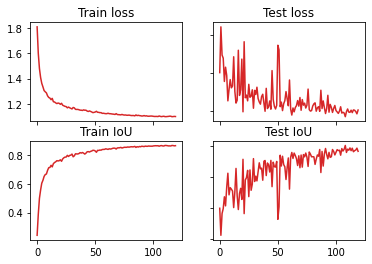

In [9]:
import matplotlib.pyplot as plt

# plot_train = np.loadtxt('model/plot.txt')[:,0:2]
# plot_test = np.loadtxt('model/plot.txt')[:,2:4]

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(plot_train[:,0], 'tab:red')
axs[0, 0].set_title('Train loss')
axs[0, 1].plot(plot_test[:,0], 'tab:red')
axs[0, 1].set_title('Test loss')
axs[1, 0].plot(plot_train[:,1], 'tab:red')
axs[1, 0].set_title('Train IoU')
axs[1, 1].plot(plot_test[:,1], 'tab:red')
axs[1, 1].set_title('Test IoU')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
   ax.label_outer()
    
# plt.plot(plot_test[:,0])
# plt.show()
plt.savefig('model_3DCNN/plot.png', bbox_inches='tight')
np.savetxt('model_3DCNN/plot.txt', np.hstack((plot_train,plot_test)))